In [1]:
from google.colab import files

# This will prompt you to upload a file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riyanshsachdev","key":"84f80596019e56abb20754b860eb3d95"}'}

In [2]:
# Create a directory for the Kaggle API credentials
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to that directory
!cp kaggle.json ~/.kaggle/

# Set the permissions for the file to be readable and writable only by you
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the Tuberculosis dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# Download the Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 96% 638M/663M [00:03<00:00, 194MB/s]
100% 663M/663M [00:06<00:00, 101MB/s]
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.26G/2.29G [00:31<00:00, 39.2MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.1MB/s]


In [4]:
# Unzip the Tuberculosis dataset
!unzip -q tuberculosis-tb-chest-xray-dataset.zip

# Unzip the Pneumonia dataset
!unzip -q chest-xray-pneumonia.zip

data pp integ etc.

In [6]:
import os
import shutil
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [7]:

#dataset paths
tb_source_path = '/content/TB_Chest_Radiography_Database/Tuberculosis'
normal_source_path_tb = '/content/TB_Chest_Radiography_Database/Normal'
pneumonia_base_path = '/content/chest_xray/'


base_dest_path = '/content/combined_dataset'
tb_dest_path = os.path.join(base_dest_path, 'Tuberculosis')
pneumonia_dest_path = os.path.join(base_dest_path, 'Pneumonia')
normal_dest_path = os.path.join(base_dest_path, 'Normal')

if os.path.exists(base_dest_path):
    shutil.rmtree(base_dest_path)
os.makedirs(tb_dest_path, exist_ok=True)
os.makedirs(pneumonia_dest_path, exist_ok=True)
os.makedirs(normal_dest_path, exist_ok=True)

def copy_files(src_pattern, dest_folder):
    files = glob.glob(src_pattern)
    if not files:
        print(f"Warning: No files found for pattern {src_pattern}")
    for file in files:
        shutil.copy(file, dest_folder)

print("Copying Tuberculosis images...")
# Note: TB images might be .png or .jpg, so we'll check for both
copy_files(os.path.join(tb_source_path, '*.*'), tb_dest_path)


print("Copying Pneumonia images...")
copy_files(os.path.join(pneumonia_base_path, 'train/PNEUMONIA/*.jpeg'), pneumonia_dest_path)
copy_files(os.path.join(pneumonia_base_path, 'test/PNEUMONIA/*.jpeg'), pneumonia_dest_path)
copy_files(os.path.join(pneumonia_base_path, 'val/PNEUMONIA/*.jpeg'), pneumonia_dest_path)

print("Copying Normal images...")
# From the TB dataset
copy_files(os.path.join(normal_source_path_tb, '*.*'), normal_dest_path)
# From the Pneumonia dataset
copy_files(os.path.join(pneumonia_base_path, 'train/NORMAL/*.jpeg'), normal_dest_path)
copy_files(os.path.join(pneumonia_base_path, 'test/NORMAL/*.jpeg'), normal_dest_path)
copy_files(os.path.join(pneumonia_base_path, 'val/NORMAL/*.jpeg'), normal_dest_path)

print("\n--- Data Integration Complete ---")
print(f"Total Tuberculosis images: {len(os.listdir(tb_dest_path))}")
print(f"Total Pneumonia images: {len(os.listdir(pneumonia_dest_path))}")
print(f"Total Normal images: {len(os.listdir(normal_dest_path))}")

Copying Tuberculosis images...
Copying Pneumonia images...
Copying Normal images...

--- Data Integration Complete ---
Total Tuberculosis images: 700
Total Pneumonia images: 4273
Total Normal images: 5083


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Define Constants ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
base_dest_path = '/content/combined_dataset'

# --- Create ImageDataGenerator for Training (with augmentation) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    validation_split=0.2,      # Split 20% of the data for validation
    rotation_range=20,         # Randomly rotate images
    width_shift_range=0.2,     # Randomly shift images horizontally
    height_shift_range=0.2,    # Randomly shift images vertically
    shear_range=0.2,           # Shear transformation
    zoom_range=0.2,            # Randomly zoom in on images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

# --- Create ImageDataGenerator for Validation (only rescaling) ---
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2       # Same split to ensure no data overlap
)

# --- Create Data Generators from the directory ---
# Training Generator
train_generator = train_datagen.flow_from_directory(
    base_dest_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    subset='training'         # Specify this is the training set
)

# Validation Generator
validation_generator = validation_datagen.flow_from_directory(
    base_dest_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'       # Specify this is the validation set
)

print("\n--- Data Generators Re-created ---")
# Verify the class indices
print("Class Indices:", train_generator.class_indices)

Found 8046 images belonging to 3 classes.
Found 2010 images belonging to 3 classes.

--- Data Generators Re-created ---
Class Indices: {'Normal': 0, 'Pneumonia': 1, 'Tuberculosis': 2}


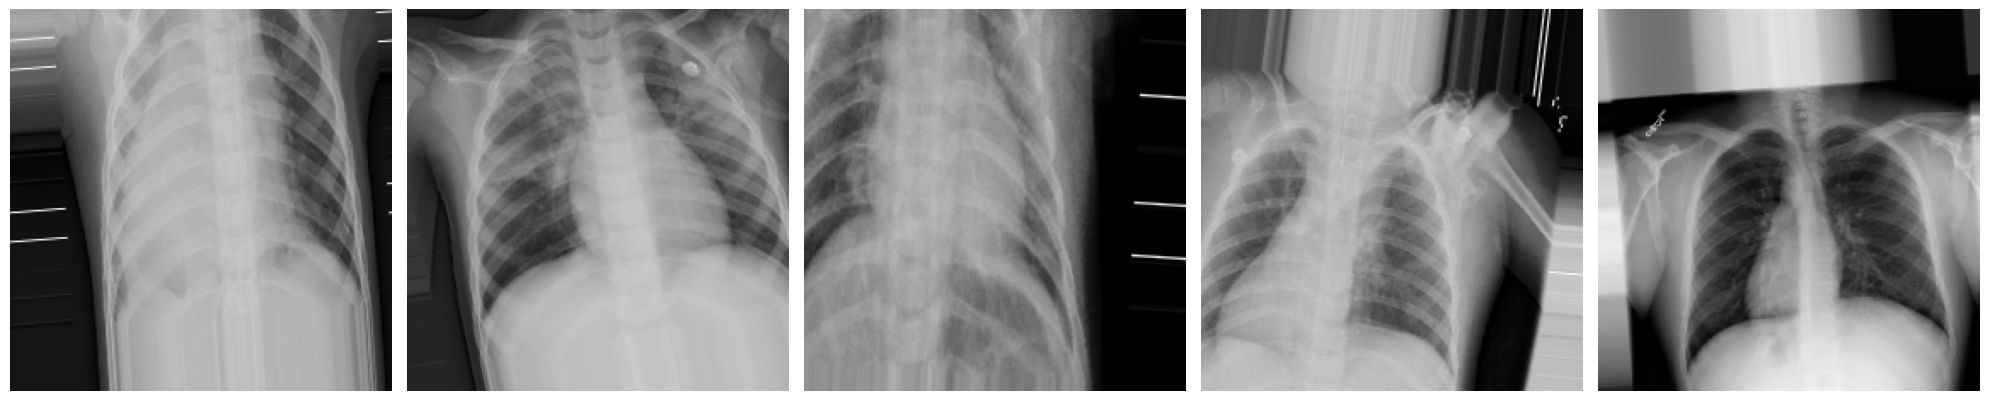

In [9]:
# --- Visualize a batch of augmented images ---
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images from the training generator
images, labels = next(train_generator)
plot_images(images[:5]) # Plot the first 5 images from the batch

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#load resnet

# We use 'imagenet' weights and exclude the final classification layer (include_top=False)
# input_shape should match our image dimensions
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
base_model.trainable = True
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), # Use a much lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
'''weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(zip(np.unique(train_generator.classes), weights))

print("--- Class Weights ---")
print(f"Labels: {train_generator.class_indices}")
print(f"Calculated Weights: {class_weights}")
'''


'weights = class_weight.compute_class_weight(\n    \'balanced\',\n    classes=np.unique(train_generator.classes),\n    y=train_generator.classes\n)\nclass_weights = dict(zip(np.unique(train_generator.classes), weights))\n\nprint("--- Class Weights ---")\nprint(f"Labels: {train_generator.class_indices}")\nprint(f"Calculated Weights: {class_weights}")\n'

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
print("\n--- Starting Fine-Tuning ---")

# Define how many more epochs to train for
fine_tune_epochs = 10
total_epochs = 15 + fine_tune_epochs # 15 is where the previous training stopped

# Continue training from where we left off
history_fine_tune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1, # Start from the last epoch number
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping] # Use the same early stopping callback
)


--- Starting Fine-Tuning ---
Epoch 16/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 181s 720ms/step - accuracy: 0.7553 - loss: 0.8175 - val_accuracy: 0.4488 - val_loss: 1.2692
Epoch 17/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 172s 681ms/step - accuracy: 0.7218 - loss: 0.8068 - val_accuracy: 0.4537 - val_loss: 1.3389
Epoch 18/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 170s 675ms/step - accuracy: 0.7048 - loss: 0.7842 - val_accuracy: 0.4547 - val_loss: 1.4180
Epoch 19/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 169s 672ms/step - accuracy: 0.6813 - loss: 0.7953 - val_accuracy: 0.4587 - val_loss: 1.3991
Epoch 20/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 170s 673ms/step - accuracy: 0.7102 - loss: 0.7863 - val_accuracy: 0.4557 - val_loss: 1.4295
Epoch 21/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 168s 667ms/step - accuracy: 0.6957 - loss: 0.7518 - val_accuracy: 0.4587 - val_loss: 1.4104


MobileNetV2

In [ ]:
'''from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt'''

In [ ]:
#base_model_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freeze the base model ---
#base_model_mobile.trainable = False


In [ ]:
'''x = base_model_mobile.output
x = GlobalAveragePooling2D()(x)#vector
x = Dense(1024, activation='relu')(x)#non linearity
predictions = Dense(3, activation='softmax')(x)#sum 1 prob dist

model_mobile = Model(inputs=base_model_mobile.input, outputs=predictions)'''

In [5]:
'''model_mobile.compile(optimizer=Adam(learning_rate=0.001), #standard learning rate for initial training
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_mobile.summary()'''

"model_mobile.compile(optimizer=Adam(learning_rate=0.001), #standard learning rate for initial training\n                     loss='categorical_crossentropy',\n                     metrics=['accuracy'])\n\nmodel_mobile.summary()"

In [ ]:
'''early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_mobile = model_mobile.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    class_weight=class_weights
)'''

Epoch 1/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 202s 741ms/step - accuracy: 0.8377 - loss: 0.4883 - val_accuracy: 0.8741 - val_loss: 0.2942
Epoch 2/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 163s 646ms/step - accuracy: 0.9424 - loss: 0.1330 - val_accuracy: 0.8672 - val_loss: 0.3264
Epoch 3/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 161s 641ms/step - accuracy: 0.9544 - loss: 0.1139 - val_accuracy: 0.9154 - val_loss: 0.2127
Epoch 4/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 161s 641ms/step - accuracy: 0.9561 - loss: 0.1037 - val_accuracy: 0.8423 - val_loss: 0.4101
Epoch 5/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 162s 643ms/step - accuracy: 0.9506 - loss: 0.1111 - val_accuracy: 0.9030 - val_loss: 0.2416
Epoch 6/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 163s 645ms/step - accuracy: 0.9632 - loss: 0.0927 - val_accuracy: 0.8766 - val_loss: 0.3150
Epoch 7/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 164s 653ms/step - accuracy: 0.9628 - loss: 0.0892 - val_accuracy: 0.9095 - val_loss: 0.2330
Epoch 8/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 165s 656ms/step - accuracy: 0.9663 -

inception v3 model


In [15]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping here

# Load pretrained InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze the base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[early_stopping])


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7233 - loss: 0.7026

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


252/252 ━━━━━━━━━━━━━━━━━━━━ 212s 770ms/step - accuracy: 0.7235 - loss: 0.7019 - val_accuracy: 0.6965 - val_loss: 0.6192
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 171s 680ms/step - accuracy: 0.8633 - loss: 0.3577 - val_accuracy: 0.7453 - val_loss: 0.5560
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 173s 685ms/step - accuracy: 0.8819 - loss: 0.3126 - val_accuracy: 0.7348 - val_loss: 0.5688
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 172s 681ms/step - accuracy: 0.8950 - loss: 0.2749 - val_accuracy: 0.8189 - val_loss: 0.4670
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 172s 684ms/step - accuracy: 0.9051 - loss: 0.2549 - val_accuracy: 0.7657 - val_loss: 0.5163
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 175s 695ms/step - accuracy: 0.9078 - loss: 0.2531 - val_accuracy: 0.8154 - val_loss: 0.4367
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 174s 692ms/step - accuracy: 0.9080 - loss: 0.2445 - val_accuracy: 0.8224 - val_loss: 0.4364
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 175s 696ms/step - accuracy: 0.9125 - loss: 0.23

custom cnn

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#custom model architecture
custom_model = Sequential([
    #1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    # 2nd cb
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3rd cb
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output from the convolutional blocks
    Flatten(),

    # Fully-connected layers
    Dense(512, activation='relu'),
    Dropout(0.5), # Add Dropout for regularization to prevent overfitting
    Dense(3, activation='softmax') # Final output layer for our 3 classes
])

# Compile the model
custom_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

custom_model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_282 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_283 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_284 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_custom = custom_model.fit(
    train_generator,
    epochs=24,
    validation_data=validation_generator
)

Epoch 1/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 182s 692ms/step - accuracy: 0.7204 - loss: 0.8441 - val_accuracy: 0.7189 - val_loss: 0.6266
Epoch 2/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 168s 666ms/step - accuracy: 0.8634 - loss: 0.3669 - val_accuracy: 0.6711 - val_loss: 0.6613
Epoch 3/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 168s 666ms/step - accuracy: 0.8901 - loss: 0.3036 - val_accuracy: 0.5527 - val_loss: 0.8247
Epoch 4/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 169s 669ms/step - accuracy: 0.8199 - loss: 0.4800 - val_accuracy: 0.6950 - val_loss: 0.7468
Epoch 5/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 166s 657ms/step - accuracy: 0.8629 - loss: 0.3475 - val_accuracy: 0.6179 - val_loss: 0.9507
Epoch 6/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 167s 664ms/step - accuracy: 0.9072 - loss: 0.2584 - val_accuracy: 0.7527 - val_loss: 0.5737
Epoch 7/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 167s 663ms/step - accuracy: 0.8923 - loss: 0.2861 - val_accuracy: 0.5204 - val_loss: 0.9057
Epoch 8/24
252/252 ━━━━━━━━━━━━━━━━━━━━ 167s 662ms/step - accuracy: 0.9079 -

comparison

In [38]:
# =============================================
# ✅ Manually Rebuilt Histories (Accurate Values)
# =============================================

# 1️⃣ ResNet50
history_resnet = {
    'history': {
        'val_accuracy':[
    0.0781, 0.1124, 0.3532, 0.4502, 0.4134, 0.4542, 0.4383, 0.4498, 0.4736,
    0.4299, 0.4413, 0.4478, 0.4448, 0.4642, 0.4458, 0.4488, 0.4537, 0.4547,
    0.4587, 0.4557, 0.4587
    ],
        'val_loss': [
    1.3394, 1.1913, 1.1526, 1.1792, 1.1483, 1.1733, 1.2354, 1.2056, 1.4033,
    1.1225, 1.8349, 1.5606, 1.1876, 1.3540, 1.3131, 1.2692, 1.3389, 1.4180,
    1.3991, 1.4295, 1.4104
    ]
    }
}

# 2️⃣ InceptionV3
history_inception = {
    'history': {
        'val_accuracy': [
            0.6965, 0.7453, 0.7348, 0.8189, 0.7657, 0.8154, 0.8224, 0.8313,
            0.8095, 0.8438, 0.8368, 0.8318, 0.7622, 0.8234, 0.8483, 0.8453,
            0.7915, 0.8289, 0.8433, 0.8179
        ],
        'val_loss': [
            0.6192, 0.5560, 0.5688, 0.4670, 0.5163, 0.4367, 0.4364, 0.4190,
            0.4638, 0.4039, 0.4217, 0.4247, 0.5188, 0.4416, 0.3883, 0.4114,
            0.4901, 0.4319, 0.3887, 0.4491
        ]
    }
}

# 3️⃣ Custom CNN
history_custom = {
    'history': {
        'val_accuracy': [
            0.7189, 0.6711, 0.5527, 0.6950, 0.6179, 0.7527, 0.5204, 0.8085,
            0.6622, 0.7020, 0.8209, 0.6582, 0.7219, 0.7632, 0.8398, 0.7388,
            0.6353, 0.7199, 0.8393, 0.8393, 0.8333, 0.8249, 0.8433, 0.8214
        ],
        'val_loss': [
            0.6266, 0.6613, 0.8247, 0.7468, 0.9507, 0.5737, 0.9057, 0.4669,
            0.6773, 0.6321, 0.4272, 0.7882, 0.6267, 0.5539, 0.4108, 0.5741,
            0.8116, 0.6539, 0.3781, 0.3943, 0.4231, 0.4343, 0.4053, 0.4629
        ]
    }
}


In [39]:
import pandas as pd
import numpy as np

def extract_metrics(history):
    h = history['history']
    acc = h.get('accuracy', [])
    val_acc = h.get('val_accuracy', [])
    loss = h.get('loss', [])
    val_loss = h.get('val_loss', [])
    return np.array(acc), np.array(val_acc), np.array(loss), np.array(val_loss)

models = {
    'ResNet50': history_resnet,
    'InceptionV3': history_inception,
    'Custom CNN': history_custom
}

summary = []
for name, hist in models.items():
    acc, val_acc, loss, val_loss = extract_metrics(hist)
    best_val_acc_epoch = np.argmax(val_acc) + 1
    best_val_loss_epoch = np.argmin(val_loss) + 1
    summary.append({
        "Model": name,
        "Epochs": len(val_acc),
        "Best Val Accuracy": round(np.max(val_acc)*100, 2),
        "At Epoch": best_val_acc_epoch,
        "Min Val Loss": round(np.min(val_loss), 4),
        "At Epoch (Loss)": best_val_loss_epoch
    })

df_summary = pd.DataFrame(summary)
display(df_summary.sort_values(by="Best Val Accuracy", ascending=False))


,Model,Epochs,Best Val Accuracy,At Epoch,Min Val Loss,At Epoch (Loss)
1,InceptionV3,20,84.83,15,0.3883,15
2,Custom CNN,24,84.33,23,0.3781,19
0,ResNet50,21,47.36,9,1.1225,10


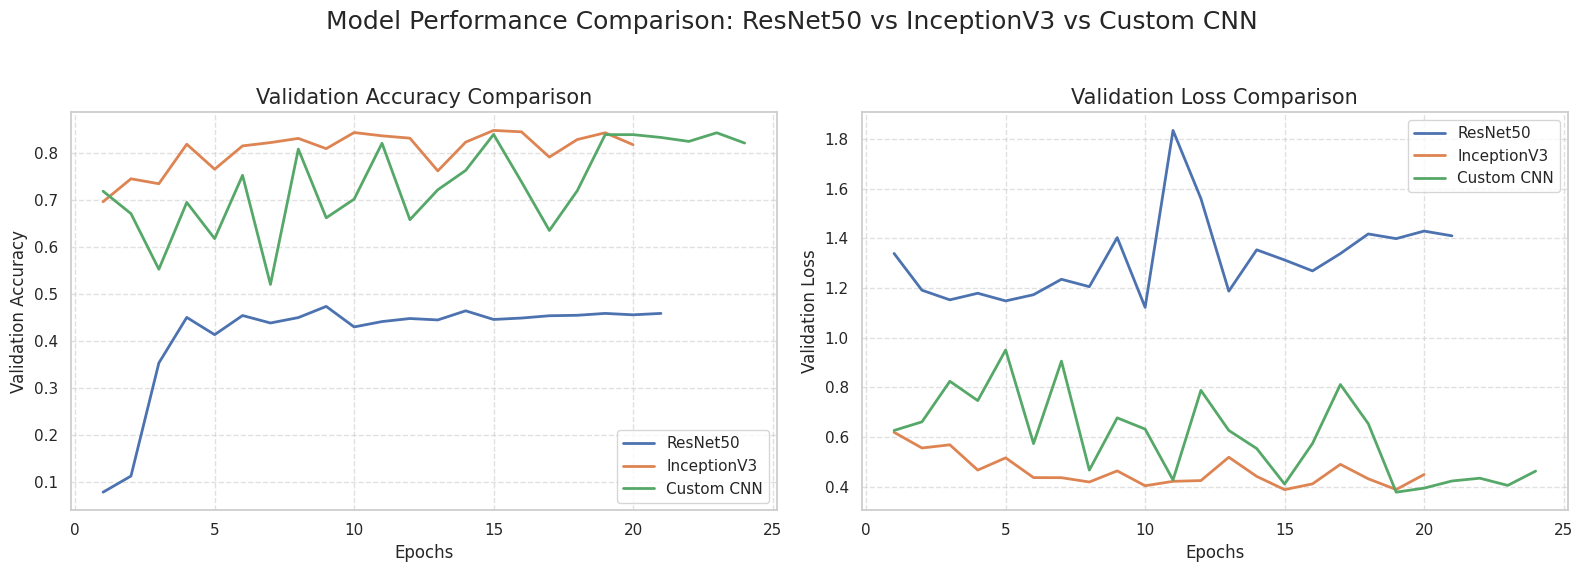

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

# Accuracy Plot
plt.subplot(1,2,1)
for name, hist in models.items():
    val_acc = hist['history']['val_accuracy']
    plt.plot(range(1, len(val_acc)+1), val_acc, label=name, linewidth=2)
plt.title('Validation Accuracy Comparison', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss Plot
plt.subplot(1,2,2)
for name, hist in models.items():
    val_loss = hist['history']['val_loss']
    plt.plot(range(1, len(val_loss)+1), val_loss, label=name, linewidth=2)
plt.title('Validation Loss Comparison', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Model Performance Comparison: ResNet50 vs InceptionV3 vs Custom CNN', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [45]:
best_model = df_summary.iloc[df_summary['Best Val Accuracy'].idxmax()]

print(f"Best Performing Model: {best_model['Model']}")
print(f"Best Validation Accuracy: {best_model['Best Val Accuracy']}% (Epoch {best_model['At Epoch']})")
print(f"Minimum Validation Loss: {best_model['Min Val Loss']} (Epoch {best_model['At Epoch (Loss)']})")


Best Performing Model: InceptionV3
Best Validation Accuracy: 84.83% (Epoch 15)
Minimum Validation Loss: 0.3883 (Epoch 15)
